# Modeling task 1.

Данный ноутбук направлен на решение 1 задачи: классификации по признаку кавер-оригинал.

Импортируем библиотеки и задаём random_state

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm
import copy

from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score, StratifiedKFold, GridSearchCV, train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.dummy import DummyClassifier
from catboost import CatBoostClassifier

import pickle

from typing import List

In [2]:
RANDOM_STATE = 54321

## Загрузка и разделение признаков

In [3]:
PATH_TRAIN = 'data/preprocessing/train_task_1.csv'
PATH_TEST = 'data/preprocessing/test_task_1.csv'

PATH_TO_SAVE_MODEL = 'models/task_1_model.pkl'

Загрузим датасет для обучения и решения первой задачи.

In [4]:
df_train = pd.read_csv(PATH_TRAIN)
df_test = pd.read_csv(PATH_TEST)

Проверим разхмеры датасетов

In [5]:
df_train.shape, df_test.shape

((56982, 34), (56982, 34))

Cоздадим переменные для признаков и целевого признака

In [6]:
X_train = df_train.drop('target', axis=1)
y_train = df_train['target']

In [7]:
X_test = df_test.drop('target', axis=1)
y_test = df_test['target']

## Baseline модель

Учитывая, что мы имеем дело с задачей классификации, при этом в данных наблюдается явный дисбаланс классов, то в качестве **метрики** будем использовать **f1 меру**.

Создадим Baseline модель, чтобы в дальнейшем мы могли сравнивать наши модели и проверять их на адекватность. В качестве базовой модели будем использовать DummyClassifier со стратегией constant=0, так ка таких значений в датасете больше

In [8]:
dummy_model = DummyClassifier(strategy='constant', constant=1)
dummy_model.fit(X_train,y_train)
print(f'Dummy:{f1_score(dummy_model.predict(X_test),y_test)}')

Dummy:0.11367849576271186


Базовая модель показала качество равное 0,1137, попробуем улучишть его

## Выбор модели для решения задачи

Поскольку у нас очень много категориальных признаков, то будем использовать для прогноза модель CatBoostClassifier. Данная модель умеет хорошо обрабатывать категориальные признаки, и даёт весьма хорошее качество.

In [9]:
cat_features = ['language',
                'country_of_track',
                'reg_code',
                'cat_year_isrc',
                'missing_text',
                'missing_title',
                'missing_isrc',
                'genre_FOLK',
                'genre_LATINFOLK',
                'genre_POP',
                'genre_ALLROCK',
                'genre_ROCK',
                'genre_ALTERNATIVE',
                'genre_ELECTRONICS',
                'genre_SOUNDTRACK',
                'genre_RAP',
                'genre_DANCE',
                'genre_METAL',
                'genre_CLASSICALMUSIC',
                'genre_SPIRITUAL',
                'genre_RUSPOP',
                'genre_JAZZ',
                'unknown_genre',
                'genre_other',
                'genre_group_ROCK',
                'genre_group_RAP',
                'genre_group_POP',
                'genre_group_FOLK',
                'genre_group_RUS',
                'cover_word',
                'duration_flag']

Создадим нашу модель. При этом необходимо будет учесть дисбаланс классов

In [10]:
classes = np.unique(y_train)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_weights = dict(zip(classes, weights))

model = CatBoostClassifier(random_state=RANDOM_STATE, 
                           cat_features=cat_features,
                           verbose=False,
                           class_weights=class_weights)

Определять качество модели будем на кроссвалидации, при этом необходимо учесть дисбаланс классов, поэтому воспользуемся StratifiedKFold

In [11]:
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train, y_train)

In [12]:
%%time
cvs = cross_val_score(model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на тренировочном датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.73026016 0.72120943 0.71145176 0.73684211]
Среднее значение f1 на тренировочном датасете 0.7249408612990067
CPU times: total: 15min 13s
Wall time: 2min 46s


Модель показала качество значительно лучше, чем у базовой модели. Изучим полученную модель.

## Важность признаков

Обучим нашу модель и посмотрим на важность признаков

In [13]:
%%time
model.fit(X_train, y_train)

CPU times: total: 4min 31s
Wall time: 53 s


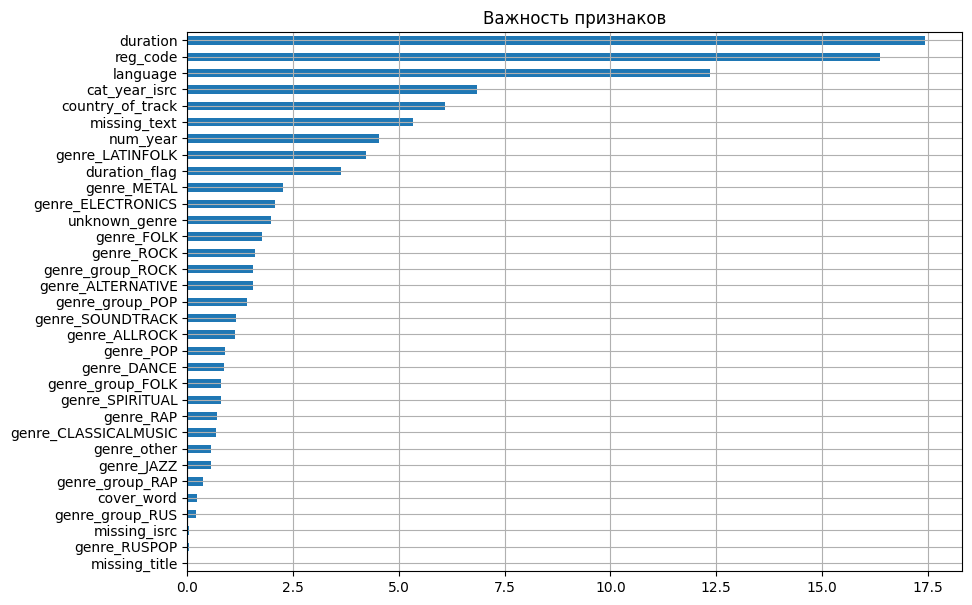

                 feature  importance
0               duration   17.444021
1               reg_code   16.360237
2               language   12.363222
3          cat_year_isrc    6.852516
4       country_of_track    6.097092
5           missing_text    5.328232
6               num_year    4.522049
7        genre_LATINFOLK    4.225133
8          duration_flag    3.639797
9            genre_METAL    2.253408
10     genre_ELECTRONICS    2.082893
11         unknown_genre    1.982114
12            genre_FOLK    1.757514
13            genre_ROCK    1.609622
14      genre_group_ROCK    1.552800
15     genre_ALTERNATIVE    1.539981
16       genre_group_POP    1.417036
17      genre_SOUNDTRACK    1.156566
18         genre_ALLROCK    1.135648
19             genre_POP    0.889482
20           genre_DANCE    0.875893
21      genre_group_FOLK    0.796915
22       genre_SPIRITUAL    0.785313
23             genre_RAP    0.692976
24  genre_CLASSICALMUSIC    0.675382
25           genre_other    0.556836
2

In [14]:
def get_feature_importance(model: CatBoostClassifier, feature_names: List):
    feature_importance_df = pd.DataFrame(
        {'feature': feature_names, 'importance': model.feature_importances_}
    )
    feature_importance_df = feature_importance_df.sort_values(
        by='importance', ascending=False
    ).reset_index(drop=True)
    
    # График
    plt.figure(figsize=(10, 7))
    importances = pd.Series(model.feature_importances_, index=feature_names).sort_values()
    importances.plot.barh(grid=True, title='Важность признаков')
    plt.show()
    
    return feature_importance_df

# Получение важности признаков и построение графика
feature_importance = get_feature_importance(model, list(X_train))

print(feature_importance)

Как видно из полученных данных для модели наибольшую важность имеют следующие признаки: длительность, код регистратора, и язык. Чуть меньше страна полученная из кода isrc, любые жанры относящиес к FOLK, отсутствующий текст и год записи.

## Подбор гиперпараметров

Чтобы ускорить отбор признаков разделим трэйновый датасет пополам

In [15]:
X_train_1, X_train_2, y_train_1, y_train_2 = train_test_split(X_train,
                                                              y_train,
                                                              random_state=RANDOM_STATE,
                                                              test_size=0.5,
                                                              stratify=y_train)

Подбор гиперпараметров будем осуществлять при помощи GridSearchCV

In [16]:
classes = np.unique(y_train_1)
weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train_1)
class_weights = dict(zip(classes, weights))

model = CatBoostClassifier(random_state=RANDOM_STATE, 
                           cat_features=cat_features,
                           verbose=False,
                           class_weights=class_weights)

In [17]:
cat_params = {'max_depth': [1, 5, 10],
             'n_estimators': range(500, 2000, 500),
             'learning_rate': [0.01, 0.03, 0.1]}

In [18]:
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train_1, y_train_1)

In [19]:
%%time
grid_search = GridSearchCV(model,
                           cat_params,
                           cv=folds,
                           n_jobs=-1,
                           scoring='f1',
                           verbose=False)

grid_search.fit(X_train_1, y_train_1)

CPU times: total: 7min 18s
Wall time: 32min 56s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000029A4FB94B30>,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000029A4FAF3A30>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.03, 0.1],
                         'max_depth': [1, 5, 10],
                         'n_estimators': range(500, 2000, 500)},
             scoring='f1', verbose=False)

Выведем лучшие параметры и метрику на такой сетке

In [20]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

In [21]:
grid_search.best_score_

0.7685834582986608

Исследуем гиперпараметры на более мелкой сетке. Оптимизировать будем уже только n_estimators и learning_rate

In [22]:
cat_params = {'max_depth': [10],
             'n_estimators': [750, 1000, 1250],
             'learning_rate': [0.05, 0.1, 0.12]}

In [23]:
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train_1, y_train_1)

In [24]:
%%time
grid_search = GridSearchCV(model,
                           cat_params,
                           cv=folds,
                           n_jobs=-1,
                           scoring='f1',
                           verbose=False)

grid_search.fit(X_train_1, y_train_1)

CPU times: total: 7min 54s
Wall time: 20min 49s


GridSearchCV(cv=<generator object _BaseKFold.split at 0x0000029A4FB95BD0>,
             estimator=<catboost.core.CatBoostClassifier object at 0x0000029A4FAF3A30>,
             n_jobs=-1,
             param_grid={'learning_rate': [0.05, 0.1, 0.12], 'max_depth': [10],
                         'n_estimators': [750, 1000, 1250]},
             scoring='f1', verbose=False)

In [25]:
grid_search.best_params_

{'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 1000}

In [26]:
grid_search.best_score_

0.7685834582986608

Лучшие параметры остались те же, поэтому дальнейшую работу будем проводить именно с ними.

Проверим качество модели на кроссвалидации на полном трейновом датасете

In [27]:
skf = StratifiedKFold(n_splits=4)
folds = skf.split(X_train_1, y_train_1)

In [28]:
model = CatBoostClassifier(random_state=RANDOM_STATE, 
                           cat_features=cat_features,
                           verbose=False,
                           class_weights=class_weights,
                           max_depth=10,
                           n_estimators=1000,
                           learning_rate=0.1)

In [29]:
%%time
cvs = cross_val_score(model, X_train, y_train, cv=folds, scoring='f1')
print(f'Метрика f1 на кроссвалидации {cvs}')
print(f'Среднее значение f1 на тренировочном датасете {mean(cvs)}')

Метрика f1 на кроссвалидации [0.77364506 0.75958188 0.7470651  0.76662909]
Среднее значение f1 на тренировочном датасете 0.7617302820446092
CPU times: total: 28min 29s
Wall time: 8min 27s


## Проверка на тестовом датасете

Проверим качество нашей модели на тренировочном датасете. Для этого обучим модель.

In [30]:
model = CatBoostClassifier(random_state=RANDOM_STATE, 
                           cat_features=cat_features,
                           verbose=200,
                           class_weights=class_weights,                        
                           max_depth=10,
                           n_estimators=1000,
                           learning_rate=0.1,
                           thread_count=-1)

In [31]:
%%time
model.fit(X_train, y_train)

0:	learn: 0.5500304	total: 151ms	remaining: 2m 30s
200:	learn: 0.0586612	total: 45.5s	remaining: 3m
400:	learn: 0.0370317	total: 1m 39s	remaining: 2m 29s
600:	learn: 0.0280317	total: 2m 35s	remaining: 1m 43s
800:	learn: 0.0216715	total: 3m 33s	remaining: 53s
999:	learn: 0.0205519	total: 4m 20s	remaining: 0us
CPU times: total: 12min 6s
Wall time: 4min 21s


Посчитаем качество модели на тестовой выборке

In [41]:
f1_score(y_test, model.predict(X_test))

0.7835703001579778

Скор значительно подрос на тесте, но вероятнее всего это связано с тем, что в тестовой выборке были просто более подходящие образцы. Которые модель определяет более уверенно.

Переучивать данную модель на всех данных не будем, поскольку она нам потребуется для решения 3 задачи и мы воспользуемся той же тестовой выборкой, чтобы убедиться, что модель будет работать корректно.

Сохраним обученную модель.

In [38]:
pickle.dump(model, open(PATH_TO_SAVE_MODEL, "wb"))

## Выводы

В данном разделе было предложено решение задачи классификации по признаку кавер-оригинал. При решении задачи было сделано:
- для классификации выбран CatBoostClassifier, поскольку у нас много категориальных признаков. В качестве метрики выбрана f1 мера, поскольку у нас сильный дисбаланс классов;
- обучена Dummy модель в качестве безлайна, которая задала минимальное значение метрики, которое удалоь значительно улучшить (0.1137);
- обучена модель CatBoostClassifier, которая на кроссвалидации показала качество метрики равное 0.7249;
- проведён анализ признаков и, как видно из полученных данных, для модели наибольшую важность имеют следующие признаки: длительность, код регистратора, и язык. Чуть меньше страна полученная из кода isrc, любые жанры относящиес к FOLK, отсутствующий текст и год записи;
- подобраны гиперпарамтеры при помощи GridSearchCV, что позволило улучшить качество модели до 0.7617
- проверено качество модели на тестовой выборке, образцы из которой модель никогда не видела, значение метрики оказалось равно 0.7836, что сопоставимо со значениями на кроссвалидации, поэтому можно говорить о стабильной работе модели.